In [1]:
import os
import shutil
import glob
import logging
import random
from pathlib import Path

import cv2
import PIL.Image as Image
#from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.models import resnet152
import albumentations as A
#from fastai.vision.models import DynamicUnet
#import holocron.models as models  # For UNet++ and UNet+++

In [2]:
def get_image_metadata(path_to_file):
    """Function for extracting metadata from filename of dataset provided by AstraZeneca.
    
    B02   - well (row B, column 02) 
    T0001 - timepoint (irrelevant for this dataset) 
    F001  - field of view = site 
    L01   - timeline (irrelevant for this datset) 
    A01   - action list number (3 fluorescent + 1 brightfield action) 
    Z01   - 3D z-number (slice number or vertical position) 
    C01   - imaging channel (1 nuclear, 2 lipids, 3 cytoplasm, 4 brightfield)
    """
    string_arr = os.path.basename(path_to_file).split("_")
    row_col = string_arr[-2] # Row and column
    timepoint = string_arr[-1][:5]
    fied_of_view = string_arr[-1][5:9]
    timeline = string_arr[-1][9:12]
    action_list_number = string_arr[-1][12:15]
    z_number_3d = string_arr[-1][15:18]
    imaging_channel = string_arr[-1][18:21]
    return {
        "row_col":       row_col,
        #"timepoint":     timepoint,  # apparently irrelevant
        "field of view": fied_of_view,
        #"timeline": timeline,  # apparently irrelevant
        "action_list_number": action_list_number,
        "z_number_3d": z_number_3d,
        "imaging_channel": imaging_channel,
        "path": path_to_file
    }

In [3]:
def divide_astra_zeneca_train_validation(dataset_path="/content/images_for_preview", train_ratio=0.5):
    """Divide sample images for the Astra Zeneca competition into training and validation sets.

    Group by row_col and field of view
    # row_col
    # field of view
      
    Input and Target share these common values:
    - row_col       = sample id? 
    - field of view = amount of zoom

    For identifying INPUT:
    - action_list_number A04
    - imaging_channel    C04
    - z_number_3d        Z01 - Z07

    For identifying TARGET:
    - action_list_number A01 A02 and A03
    - imaging_channel    C01, C02, C03
    - z_number_3d        Z01
    """

    dataset_samples = glob.glob(os.path.join(dataset_path, "*/*/Assay*"))

    dataset_dicts = [get_image_metadata(path) for path in dataset_samples]

    # Group all 7 inputs with all 3 respective targets into variable sample
    samples = dict()
    for sample_dict in dataset_dicts:
        sample_key = (sample_dict["row_col"], sample_dict["field of view"])

        if samples.get(sample_key) is None:
            samples[sample_key] = {
                "input": dict(),
                "target": dict()
            }

        if sample_dict["action_list_number"] == "A04": # or sample_dict["imaging_channel"] == "C04"
            # Is an input
            z_number_3d = sample_dict["z_number_3d"]
            samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
        else:
            # Is an target
            action_list_number = sample_dict["action_list_number"]
            samples[sample_key]["target"][action_list_number] = sample_dict["path"]

    samples = list(samples.values())

    # Modulo
    if os.path.isdir("../data/02_train_valid/train"):
        shutil.rmtree("../data/02_train_valid/train")
    if os.path.isdir("../data/02_train_valid/valid"):
        shutil.rmtree("../data/02_train_valid/valid")

    Path("../data/02_train_valid/valid/input").mkdir(exist_ok=True, parents=True)
    Path("../data/02_train_valid/valid/targets").mkdir(exist_ok=True, parents=True)
    Path("../data/02_train_valid/train/input").mkdir(exist_ok=True, parents=True)
    Path("../data/02_train_valid/train/targets").mkdir(exist_ok=True, parents=True)

    crop_size = (256, 256)

    for idx in range(len(samples)):
        sample_dict = samples[idx]

        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert crop_size[0] <= w
        assert crop_size[1] <= h

        input = torch.zeros((7, w, h))
        output = torch.zeros((3, w, h))
        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]

            img = cv2.imread(img_path, -1)

            w, h = img.shape
            
            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]

            filename = os.path.basename(img_path)
            save_path_train = os.path.join("../data/02_train_valid/train/input", filename)
            save_path_valid = os.path.join("../data/02_train_valid/valid/input", filename)
            cv2.imwrite(save_path_train, train_img)
            cv2.imwrite(save_path_valid, valid_img)

        for i, action_list_number in enumerate(["A01", "A02", "A03"]):
            img_path = sample_dict["target"][action_list_number]

            img = cv2.imread(img_path, -1)

            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]

            filename = os.path.basename(img_path)
            save_path_train = os.path.join("../data/02_train_valid/train/targets", filename)
            save_path_valid = os.path.join("../data/02_train_valid/valid/targets", filename)
            cv2.imwrite(save_path_train, train_img)
            cv2.imwrite(save_path_valid, valid_img)

#divide_astra_zeneca_train_validation("../images_for_preview", train_ratio=0.5)

## Removing magnification bias

The input images contained biased and will therefore be normalized

### Input data:

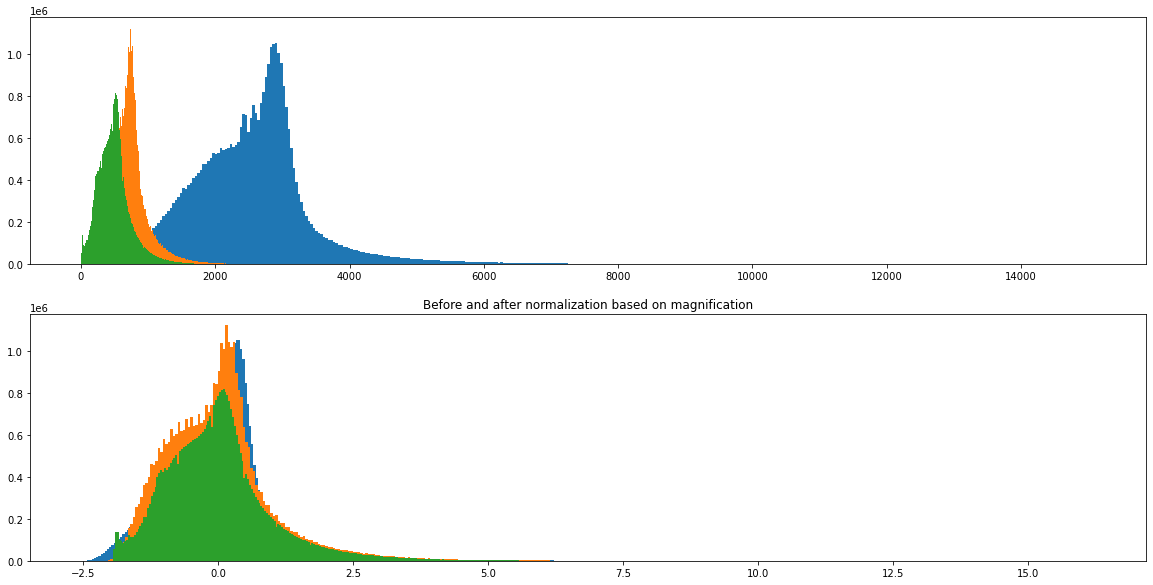

In [4]:
fig, axs = plt.subplots(2, figsize=(20,10))
plt.title("Before and after normalization based on magnification")

normalization_dict = {}

for magnification in [20, 40, 60]:
    paths = glob.glob(f"../data/01_raw/images_for_preview/{magnification}*/input/*")
    
    pixel_values = list()
    for i in paths:
        img = cv2.imread(i, -1)
        pixel_values.append(img.flatten())
    pixel_values = np.concatenate(pixel_values)
    
    mean_pixel = np.mean(pixel_values)
    std_pixel = np.std(pixel_values)
    normalization_dict[magnification] = {
        "mean": mean_pixel,
        "std": std_pixel
    }

    axs[0].hist(pixel_values, bins=400)
    axs[1].hist((pixel_values-mean_pixel)/std_pixel, bins=400)
plt.show()

Let's make a function which normalizes and saves it as a new image

In [5]:

path_to_data = "../data/"
input_data_folder_name = "01_raw"
new_data_folder_name = "02_normalized_images"


for magnification in [20, 40, 60]:
    Path(os.path.join(path_to_data, new_data_folder_name, f"images_for_preview/{magnification}x images/input")).mkdir(
        exist_ok=True, 
        parents=True
    )
    paths = glob.glob(os.path.join(path_to_data,f"{input_data_folder_name}/images_for_preview/{magnification}*/input/Assay*"))
    for path in paths:
        img = cv2.imread(path, -1)
        
        mean_pixel = normalization_dict[magnification]["mean"]
        std_pixel = normalization_dict[magnification]["std"]
        new_img = (img-mean_pixel)/std_pixel
        
        # Save normalized image
        save_path = path.replace(input_data_folder_name, "02_normalized_images").replace("\\","/")
        success = cv2.imwrite(save_path, new_img)
        if not success:
            print(f"Failed to save: {save_path}")

## Target data:

### Target A01

Let's visualize the pixel values using mean and standard deviation

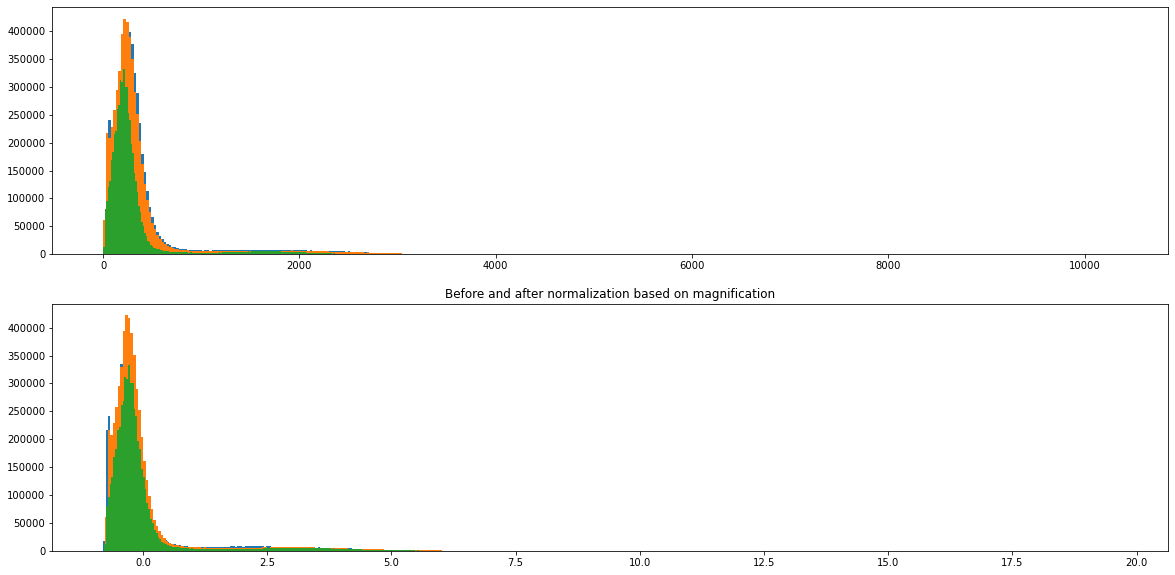

In [45]:
fig, axs = plt.subplots(2, figsize=(20,10))
plt.title("Before and after normalization based on magnification")

normalization_dict = {}

for magnification in [20, 40, 60]:
    paths = glob.glob(f"../data/01_raw/images_for_preview/{magnification}*/targets/*A01*")

    pixel_values = list()
    for i in paths:
    
        img = cv2.imread(i, -1)
        pixel_values.append(img.flatten())
    pixel_values = np.concatenate(pixel_values)
    
    mean_pixel = np.mean(pixel_values)
    std_pixel = np.std(pixel_values)
    normalization_dict[magnification] = {
        "mean": mean_pixel,
        "std": std_pixel
    }

    axs[0].hist(pixel_values, bins=400)
    axs[1].hist((pixel_values-mean_pixel)/std_pixel, bins=400)
plt.show()

The normalized values looks better, let's save those images

In [46]:
path_to_data = "../data/"
input_data_folder_name = "01_raw"
new_data_folder_name = "02_normalized_images"


for magnification in [20, 40, 60]:
    Path(os.path.join(path_to_data, new_data_folder_name, f"images_for_preview/{magnification}x images/targets")).mkdir(
        exist_ok=True, 
        parents=True
    )
    paths = glob.glob(os.path.join(path_to_data, input_data_folder_name, f"images_for_preview/{magnification}*/targets/*A01*"))

    for path in paths:
        img = cv2.imread(path, -1)
        
        mean_pixel = normalization_dict[magnification]["mean"]
        std_pixel = normalization_dict[magnification]["std"]
        new_img = (img-mean_pixel)/std_pixel
        
        # Save normalized image
        save_path = path.replace(input_data_folder_name, new_data_folder_name).replace("\\","/")
        print(save_path)
        success = cv2.imwrite(save_path, new_img)
        if not success:
            print(f"Failed to save: {save_path}")

../data/02_normalized_images/images_for_preview/20x images/targets/AssayPlate_Greiner_#655090_D04_T0001F006L01A01Z01C01.tif
../data/02_normalized_images/images_for_preview/40x images/targets/AssayPlate_Greiner_#655090_D04_T0001F008L01A01Z01C01.tif
../data/02_normalized_images/images_for_preview/60x images/targets/AssayPlate_Greiner_#655090_D04_T0001F012L01A01Z01C01.tif


### Target A02

Next, we try to normalize the images and visualize target A02 as well

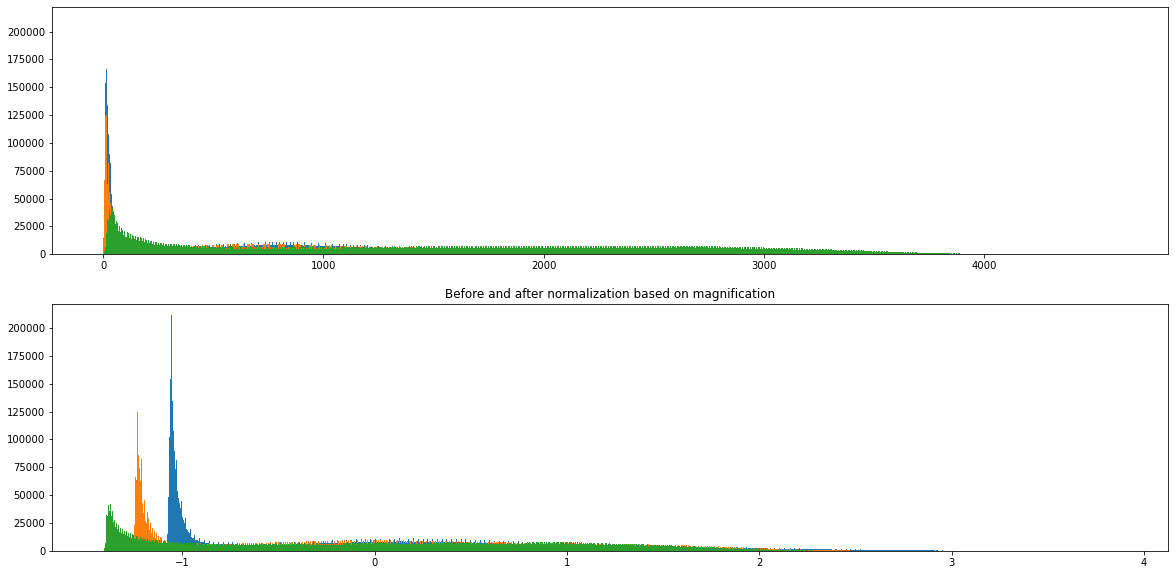

{20: {'mean': 699.4002086046321, 'std': 647.1288960083931}, 40: {'mean': 715.3041735260045, 'std': 570.8349827211225}, 60: {'mean': 1548.8837324088834, 'std': 1097.4926391826002}}


In [47]:
fig, axs = plt.subplots(2, figsize=(20,10))
plt.title("Before and after normalization based on magnification")

normalization_dict = {}

for magnification in [20, 40, 60]:
    paths = glob.glob(f"../data/01_raw/images_for_preview/{magnification}*/targets/*A02*")

    pixel_values = list()
    for i in paths:
    
        img = cv2.imread(i, -1)
        pixel_values.append(img.flatten())
    pixel_values = np.concatenate(pixel_values)
    
    mean_pixel = np.mean(pixel_values)
    std_pixel = np.std(pixel_values)
    normalization_dict[magnification] = {
        "mean": mean_pixel,
        "std": std_pixel
    }

    axs[0].hist(pixel_values, bins=1000)
    axs[1].hist((pixel_values-mean_pixel)/std_pixel, bins=1000)
plt.show()
print(normalization_dict)

The normalization does not look good due to skewed distribution. Let's skip the subtraction with mean and only divide by standard deviation

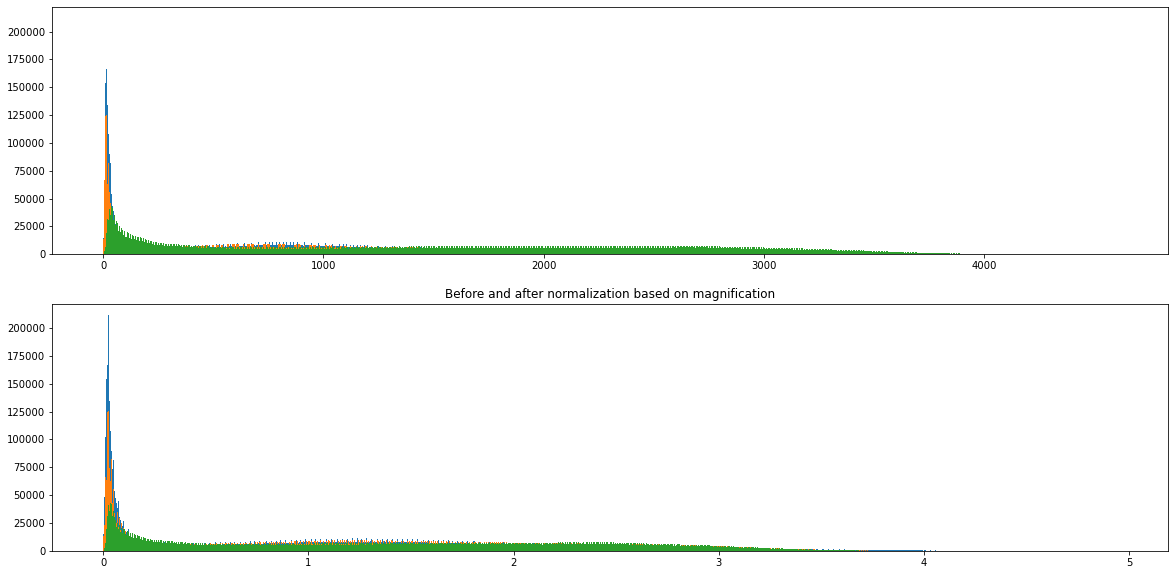

{20: {'mean': 699.4002086046321, 'std': 647.1288960083931}, 40: {'mean': 715.3041735260045, 'std': 570.8349827211225}, 60: {'mean': 1548.8837324088834, 'std': 1097.4926391826002}}


In [48]:
fig, axs = plt.subplots(2, figsize=(20,10))
plt.title("Before and after normalization based on magnification")

normalization_dict = {}

for magnification in [20, 40, 60]:
    paths = glob.glob(f"../data/01_raw/images_for_preview/{magnification}*/targets/*A02*")

    pixel_values = list()
    for i in paths:
    
        img = cv2.imread(i, -1)
        pixel_values.append(img.flatten())
    pixel_values = np.concatenate(pixel_values)
    
    mean_pixel = np.mean(pixel_values)
    std_pixel = np.std(pixel_values)
    normalization_dict[magnification] = {
        "mean": mean_pixel,
        "std": std_pixel
    }

    axs[0].hist(pixel_values, bins=1000)
    axs[1].hist(pixel_values/std_pixel, bins=1000)
plt.show()
print(normalization_dict)

This looks better, let's save it.

In [49]:
path_to_data = "../data/"
input_data_folder_name = "01_raw"
new_data_folder_name = "02_normalized_images"



for magnification in [20, 40, 60]:
    Path(os.path.join(path_to_data, new_data_folder_name, f"images_for_preview/{magnification}x images/targets")).mkdir(
        exist_ok=True, 
        parents=True
    )
    paths = glob.glob(os.path.join(path_to_data, input_data_folder_name, f"images_for_preview/{magnification}*/targets/*A02*"))
    print(paths)
    for path in paths:
        img = cv2.imread(path, -1)
        
        mean_pixel = normalization_dict[magnification]["mean"]
        std_pixel = normalization_dict[magnification]["std"]
        new_img = (img-mean_pixel)/std_pixel
        
        # Save normalized image
        save_path = path.replace(input_data_folder_name, new_data_folder_name).replace("\\\\","/")
        success = cv2.imwrite(save_path, new_img)
        if not success:
            print(f"Failed to save: {save_path}")

['../data/01_raw\\images_for_preview\\20x images\\targets\\AssayPlate_Greiner_#655090_D04_T0001F006L01A02Z01C02.tif']
['../data/01_raw\\images_for_preview\\40x images\\targets\\AssayPlate_Greiner_#655090_D04_T0001F008L01A02Z01C02.tif']
['../data/01_raw\\images_for_preview\\60x images\\targets\\AssayPlate_Greiner_#655090_D04_T0001F012L01A02Z01C02.tif']


### Target A03

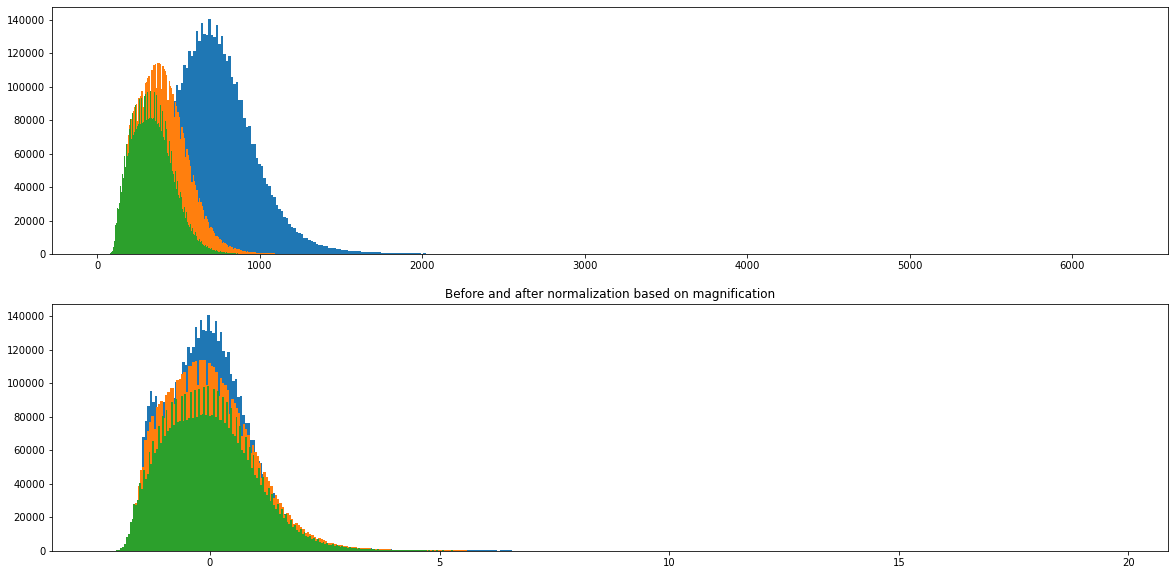

In [50]:
fig, axs = plt.subplots(2, figsize=(20,10))
plt.title("Before and after normalization based on magnification")

normalization_dict = {}

for magnification in [20, 40, 60]:
    paths = glob.glob(f"../data/01_raw/images_for_preview/{magnification}*/targets/*A03*")

    pixel_values = list()
    for i in paths:
    
        img = cv2.imread(i, -1)
        pixel_values.append(img.flatten())
    pixel_values = np.concatenate(pixel_values)
    
    mean_pixel = np.mean(pixel_values)
    std_pixel = np.std(pixel_values)
    normalization_dict[magnification] = {
        "mean": mean_pixel,
        "std": std_pixel
    }

    axs[0].hist(pixel_values, bins=400)
    axs[1].hist((pixel_values-mean_pixel)/std_pixel, bins=400)
plt.show()

In [51]:
path_to_data = "../data/"
input_data_folder_name = "01_raw"
new_data_folder_name = "02_normalized_images"
 
for magnification in [20, 40, 60]:
    Path(os.path.join(path_to_data, new_data_folder_name, f"images_for_preview/{magnification}x images/targets")).mkdir(
        exist_ok=True, 
        parents=True
    )
    paths = glob.glob(os.path.join(path_to_data, input_data_folder_name, f"images_for_preview/{magnification}*/targets/*A03*"))
    for path in paths:
        img = cv2.imread(path, -1)
        
        mean_pixel = normalization_dict[magnification]["mean"]
        std_pixel = normalization_dict[magnification]["std"]
        new_img = (img-mean_pixel)/std_pixel
        
        # Save normalized image
        save_path = path.replace(input_data_folder_name, new_data_folder_name).replace("\\","/")
        success = cv2.imwrite(save_path, new_img)
        if not success:
            print(f"Failed to save: {save_path}")

# Split train and validation dataset

In [57]:
def divide_astra_zeneca_train_validation(dataset_path, save_dir, train_ratio=0.5):
    """Divide sample images for the Astra Zeneca competition into training and validation sets.

    Group by row_col and field of view
    # row_col
    # field of view
      
    Input and Target share these common values:
    - row_col       = sample id? 
    - field of view = amount of zoom

    For identifying INPUT:
    - action_list_number A04
    - imaging_channel    C04
    - z_number_3d        Z01 - Z07

    For identifying TARGET:
    - action_list_number A01 A02 and A03
    - imaging_channel    C01, C02, C03
    - z_number_3d        Z01
    """

    dataset_samples = glob.glob(os.path.join(dataset_path, "*/*/Assay*"))
    dataset_dicts = [get_image_metadata(path) for path in dataset_samples]

    # Group all 7 inputs with all 3 respective targets into variable sample
    samples = dict()
    for sample_dict in dataset_dicts:
        sample_key = (sample_dict["row_col"], sample_dict["field of view"])

        if samples.get(sample_key) is None:
            samples[sample_key] = {
                "input": dict(),
                "target": dict()
            }

        if sample_dict["action_list_number"] == "A04": # or sample_dict["imaging_channel"] == "C04"
            # Is an input
            z_number_3d = sample_dict["z_number_3d"]
            samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
        else:
            # Is an target
            action_list_number = sample_dict["action_list_number"]
            samples[sample_key]["target"][action_list_number] = sample_dict["path"]

    samples = list(samples.values())

    # Modulo
    if os.path.isdir(os.path.join(save_dir, "train")):
        shutil.rmtree(os.path.join(save_dir, "train"))
    if os.path.isdir(os.path.join(save_dir, "valid")):
        shutil.rmtree(os.path.join(save_dir, "valid"))

    Path(os.path.join(save_dir, "valid/input")).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(save_dir, "valid/targets")).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(save_dir, "train/input")).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(save_dir, "train/targets")).mkdir(exist_ok=True, parents=True)

    crop_size = (256, 256)

    for idx in range(len(samples)):
        sample_dict = samples[idx]

        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert crop_size[0] <= w
        assert crop_size[1] <= h

        input = torch.zeros((7, w, h))
        output = torch.zeros((3, w, h))
        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]

            img = cv2.imread(img_path, -1)

            w, h = img.shape
            
            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]

            filename = os.path.basename(img_path)
            save_path_train = os.path.join(save_dir, "train/input", filename)
            save_path_valid = os.path.join(save_dir, "valid/input", filename)
            success = cv2.imwrite(save_path_train, train_img)
            if not success:
                print(f"Failed to save: {save_path}")
            success = cv2.imwrite(save_path_valid, valid_img)
            if not success:
                print(f"Failed to save: {save_path}")


        for i, action_list_number in enumerate(["A01", "A02", "A03"]):
            img_path = sample_dict["target"][action_list_number]

            img = cv2.imread(img_path, -1)

            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]

            filename = os.path.basename(img_path)
            save_path_train = os.path.join(save_dir, "train/targets", filename)
            save_path_valid = os.path.join(save_dir, "valid/targets", filename)
            success = cv2.imwrite(save_path_train, train_img)
            if not success:
                print(f"Failed to save: {save_path}")
            success = cv2.imwrite(save_path_valid, valid_img)
            if not success:
                print(f"Failed to save: {save_path}")

divide_astra_zeneca_train_validation("../data/02_normalized_images/images_for_preview", "../data/03_train_valid", train_ratio=0.5)

# Creating segmentation masks for target A1 

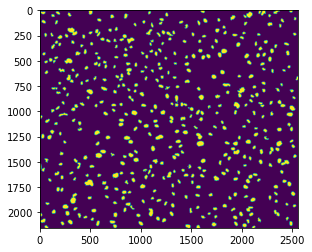

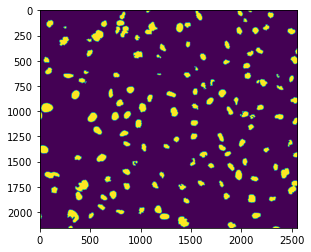

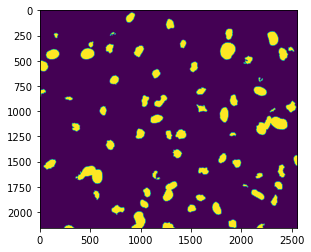

In [75]:
from skimage import morphology

paths = glob.glob(f"../data/01_raw/images_for_preview/*/targets/*A01*")
for path in paths:
    img = cv2.imread(path, -1)
    
    mask = morphology.remove_small_holes(
        morphology.remove_small_objects(
            img>2*np.mean(img), 
            500
        ),
        500
    )
    mask = morphology.opening(mask, morphology.disk(3))
    
    save_path = path.replace("01_raw", "02_normalized_images").replace("targets", "masks")
    Path(os.path.dirname(save_path)).mkdir(exist_ok=True, parents=True)
    
    new_img = np.zeros_like(mask)
    new_img[mask] = 1
    new_img = new_img.astype(np.uint8)
    
    plt.figure()
    plt.imshow(new_img)
    plt.show()
    
    success = cv2.imwrite(save_path, new_img)
    if not success:
        print(f"Failed to save: {save_path}")

In [76]:
Path(os.path.join("../data/05_masks", "train/masks")).mkdir(exist_ok=True, parents=True)
Path(os.path.join("../data/05_masks", "valid/masks")).mkdir(exist_ok=True, parents=True)

In [83]:
def divide_astra_zeneca_train_validation_w_masks(dataset_path, save_dir, train_ratio=0.5):
    """Divide sample images for the Astra Zeneca competition into training and validation sets.

    Group by row_col and field of view
    # row_col
    # field of view
      
    Input and Target share these common values:
    - row_col       = sample id? 
    - field of view = amount of zoom

    For identifying INPUT:
    - action_list_number A04
    - imaging_channel    C04
    - z_number_3d        Z01 - Z07

    For identifying TARGET:
    - action_list_number A01 A02 and A03
    - imaging_channel    C01, C02, C03
    - z_number_3d        Z01
    """

    dataset_samples = glob.glob(os.path.join(dataset_path, "*/*/Assay*"))
    dataset_dicts = [get_image_metadata(path) for path in dataset_samples]

    # Group all 7 inputs with all 3 respective targets into variable sample
    samples = dict()
    for sample_dict in dataset_dicts:
        sample_key = (sample_dict["row_col"], sample_dict["field of view"])

        if samples.get(sample_key) is None:
            samples[sample_key] = {
                "input": dict(),
                "target": dict(),
                "masks": dict()
            }

        if sample_dict["action_list_number"] == "A04": # or sample_dict["imaging_channel"] == "C04"
            # Is an input
            z_number_3d = sample_dict["z_number_3d"]
            samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
        else:
            # Is an target
            if "masks" in sample_dict["path"]:
                action_list_number = sample_dict["action_list_number"]
                samples[sample_key]["masks"][action_list_number] = sample_dict["path"]
            else:
                action_list_number = sample_dict["action_list_number"]
                samples[sample_key]["target"][action_list_number] = sample_dict["path"]

    samples = list(samples.values())
        shutil.rmtree(os.path.join(save_dir, "train"))
    if os.path.isdir(os.path.join(save_dir, "valid")):
        shutil.rmtree(os.path.join(save_dir, "valid"))

    Path(os.path.join(save_dir, "valid/input")).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(save_dir, "valid/targets")).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(save_dir, "valid/masks")).mkdir(exist_ok=True, parents=True)
    
    Path(os.path.join(save_dir, "train/input")).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(save_dir, "train/targets")).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(save_dir, "train/masks")).mkdir(exist_ok=True, parents=True)
    

    crop_size = (256, 256)

    for idx in range(len(samples)):
        sample_dict = samples[idx]

        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert crop_size[0] <= w
        assert crop_size[1] <= h

        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]

            img = cv2.imread(img_path, -1)

            w, h = img.shape
            
            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]

            filename = os.path.basename(img_path)
            save_path_train = os.path.join(save_dir, "train/input", filename)
            save_path_valid = os.path.join(save_dir, "valid/input", filename)
            success = cv2.imwrite(save_path_train, train_img)
            if not success:
                print(f"Failed to save: {save_path}")
            success = cv2.imwrite(save_path_valid, valid_img)
            if not success:
                print(f"Failed to save: {save_path}")


        for i, action_list_number in enumerate(["A01", "A02", "A03"]):
            img_path = sample_dict["target"][action_list_number]

            img = cv2.imread(img_path, -1)

            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]
            
            # Saving image
            filename = os.path.basename(img_path)
            save_path_train = os.path.join(save_dir, "train/targets", filename)
            save_path_valid = os.path.join(save_dir, "valid/targets", filename)
            success = cv2.imwrite(save_path_train, train_img)
            if not success:
                print(f"Failed to save: {save_path}")
            success = cv2.imwrite(save_path_valid, valid_img)
            if not success:
                print(f"Failed to save: {save_path}")

        for i, action_list_number in enumerate(["A01"]):#, "A02", "A03"]):
            img_path = sample_dict["masks"][action_list_number]

            img = cv2.imread(img_path, -1)

            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]
            
            # Saving image
            filename = os.path.basename(img_path)
            save_path_train = os.path.join(save_dir, "train/masks", filename)
            save_path_valid = os.path.join(save_dir, "valid/masks", filename)
            success = cv2.imwrite(save_path_train, train_img)
            if not success:
                print(f"Failed to save: {save_path}")
            success = cv2.imwrite(save_path_valid, valid_img)
            if not success:
                print(f"Failed to save: {save_path}")
                
divide_astra_zeneca_train_validation_w_masks("../data/02_normalized_images/images_for_preview", "../data/03_train_valid", train_ratio=0.5)